# UBER Pickups Project: unsupervised machine learning module

The following analysis is being done as a mandatory project for certification bloc 3 (Machine Learning Engineer at Jedha).

The project will follow the below steps:
1. Data retrieval and EDA in order to understand the pickups data in NYC ( visualizations and data interpretation)
2. Preprocessing and first approach to clustering with K-Means
3. Clustering output analysis and second approach to clustering with DBScan
4. Mapping clusters to TLC zones using the lookup file or spatial join
5. Comparative analysis of both clustering outputs, interpretation
6. Clustering visualization, identification of hot zones
7. Conclusions

In [4]:
# This script sets up the environment for a clustering analysis of Uber pickups in New York City.
# The analysis will involve clustering techniques to identify patterns in pickup locations.
# It imports necessary libraries and modules

import pandas as pd        # For loading and manipulating data
import numpy as np         # Numerical operations 

import matplotlib.pyplot as plt  # For static plots 
import seaborn as sns            # For enhanced plotting 

import plotly.express as px      # For interactive maps and visuals
import plotly.graph_objects as go # For advanced plotting capabilities
from dash import Dash, dcc, html # For building interactive web applications

from sklearn.cluster import KMeans, DBSCAN  # Unsupervised ML algorithms
from sklearn.preprocessing import StandardScaler  # For normalizing coordinates
from sklearn.metrics import silhouette_score # For evaluating clustering performance

import warnings
warnings.filterwarnings('ignore')  # required for data manipulation, visualization, and clustering algorithms.





## Part 1: Data retrieval and EDA in order to understand the pickups data in NYC 

In [5]:
# The dataset contains the Uber pickups data from April 2014 (pickup locations and timestamps)
# Load the dataset
df = pd.read_csv("uber-raw-data-apr14.csv")
df.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [6]:
# Display the shape of the DataFrame to understand its dimensions
df.shape

(564516, 4)

In [7]:
# Convert datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Extract useful features
df['Hour'] = df['Date/Time'].dt.hour
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek  # Monday=0, Sunday=6
df['DayName'] = df['Date/Time'].dt.day_name()

In [8]:
# Display the first few rows of the DataFrame to verify the changes
df.head()

,Date/Time,Lat,Lon,Base,Hour,DayOfWeek,DayName
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,0,1,Tuesday
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,0,1,Tuesday
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,0,1,Tuesday
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,0,1,Tuesday
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,0,1,Tuesday


In [9]:
# Let's filter the DataFrame to focus on specific time slots for analysis.
# Example: pickups on Friday evening (6 PM)
df_filtered = df[(df['DayOfWeek'] == 4) & (df['Hour'] == 18)] # Friday = 4

In [10]:
# Visualizing pickups on Friday at 6 PM
fig_friday_6pm = px.scatter_mapbox(
    df_filtered,
    lat="Lat",
    lon="Lon",
    zoom=10,
    height=600,
    width=900,
    title="Uber Pickups in NYC (Friday 6 PM)",
    mapbox_style="carto-positron"
)

fig_friday_6pm.show()


Pattern: High concentration of pickups in Manhattan, especially Midtown and Downtown.
Interpretation: This is the end of the workweek, many people are leaving offices, heading to social events, or traveling out of the city. The demand is high in business and entertainment districts.

In [11]:
# Let's filter the DataFrame to focus on a different time slot for analysis.
# Example: pickups on Saturday at 11 PM

df_filtered = df[(df['DayOfWeek'] == 5) & (df['Hour'] == 23)]  # Saturday = 5
fig_saturday_11pm = px.scatter_mapbox(
    df_filtered,
    lat="Lat",
    lon="Lon",
    zoom=10,
    height=600,
    width=900,
    title="Uber Pickups in NYC (Saturday 11 PM)",
    mapbox_style="carto-positron"
)
fig_saturday_11pm.show()

Pattern: Pickups are dense in nightlife areas—Lower Manhattan, East Village, Williamsburg, and parts of Brooklyn.
Interpretation: Late-night activity peaks around bars, clubs, and restaurants. People are moving between nightlife hotspots or heading home.

In [12]:
# Let's filter the DataFrame to focus on a different time slot for analysis.
# Example: pickups on Monday at 8 AM
df_filtered = df[(df['DayOfWeek'] == 0) & (df['Hour'] == 8)]  # Monday = 0
fig = px.scatter_mapbox(
    df_filtered,
    lat="Lat",
    lon="Lon",
    zoom=10,
    height=600,
    width=900,
    title="Uber Pickups in NYC (Monday 8 AM)",
    mapbox_style="carto-positron"
)
fig.show()


Pattern: Pickups cluster around residential neighborhoods and major transit hubs, with flows toward Midtown and Downtown.
Interpretation: This is the morning commute. Riders are leaving home for work, often heading to business districts or connecting to public transport.

In [13]:
## Now, let's compare the three time slots on a single map using Plotly's Scattermapbox.
# First, we need to filter the DataFrame for each time slot
# and then create a combined figure with different traces for each time slot.

df1 = df[(df['DayOfWeek'] == 4) & (df['Hour'] == 18)]  # Friday 6 PM
df2 = df[(df['DayOfWeek'] == 5) & (df['Hour'] == 23)]  # Saturday 11 PM
df3 = df[(df['DayOfWeek'] == 0) & (df['Hour'] == 8)]   # Monday 8 AM

fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    lat=df1["Lat"],
    lon=df1["Lon"],
    mode='markers',
    marker=dict(size=5, color="blue", opacity=0.5),
    name="Friday 6 PM"
))
fig.add_trace(go.Scattermapbox(
    lat=df2["Lat"],
    lon=df2["Lon"],
    mode='markers',
    marker=dict(size=5, color="red", opacity=0.5),
    name="Saturday 11 PM"
))
fig.add_trace(go.Scattermapbox(
    lat=df3["Lat"],
    lon=df3["Lon"],
    mode='markers',
    marker=dict(size=5, color="green", opacity=0.5),
    name="Monday 8 AM"
))

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox=dict(center=dict(lat=40.75, lon=-73.97), zoom=10),
    height=600,
    title="Uber Pickups Comparison: Friday 6PM, Saturday 11PM, Monday 8AM"
)

fig.show()

Overall Patterns

Temporal Shifts: The “hot zones” move depending on the day and hour—work-related on weekdays, leisure-related on weekends.

Spatial Consistency: Manhattan remains a constant high-demand area, but the exact neighborhoods shift with time.

Demand Peaks: Friday evenings and Saturday nights show the highest density, reflecting social and entertainment demand. Monday mornings are more spread out, reflecting commuting patterns.

## Part 2. Preprocessing and first approach to clustering with K-Means

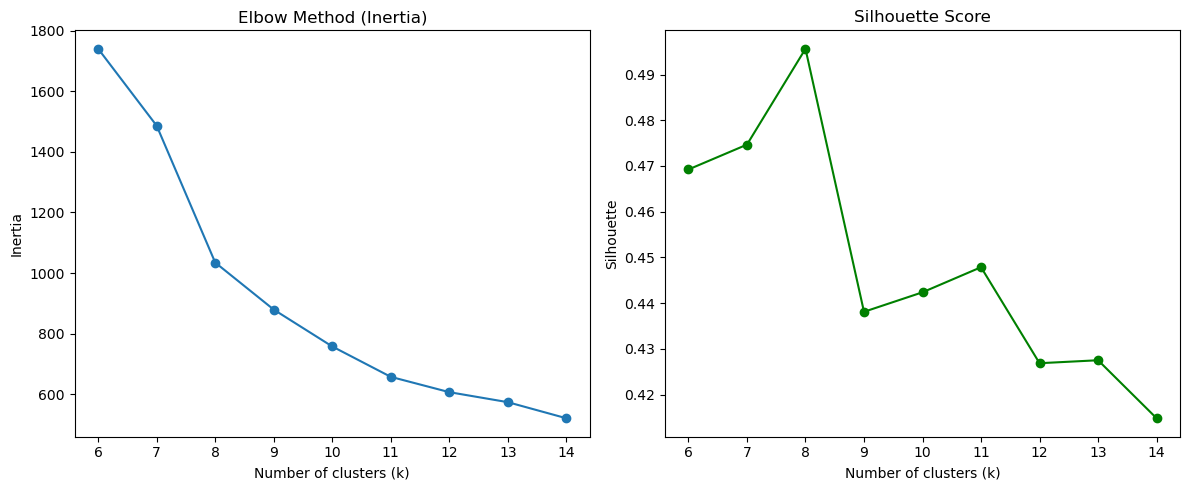

In [14]:
# First approach to clustering on the pickup locations to identify patterns. We'll use K-Means clustering for this.
# We'll start by scaling the coordinates to ensure that the clustering algorithm performs optimally.
# The elbow method and silhouette score will help us determine the optimal number of clusters.

# Scaling the coordinates

coords = df_filtered[['Lat', 'Lon']].values
coords_scaled = StandardScaler().fit_transform(coords)

# Testing a range of K values
K_range = range(6, 15)
inertia = []
silhouette = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(coords_scaled)
    
    inertia.append(model.inertia_)
    silhouette.append(silhouette_score(coords_scaled, labels))

# Plotting both metrics side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot (inertia)
ax[0].plot(K_range, inertia, marker='o')
ax[0].set_title('Elbow Method (Inertia)')
ax[0].set_xlabel('Number of clusters (k)')
ax[0].set_ylabel('Inertia')

# Silhouette scores
ax[1].plot(K_range, silhouette, marker='o', color='green')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of clusters (k)')
ax[1].set_ylabel('Silhouette')

plt.tight_layout()
plt.show()


Interpretation: acc to the elbow method the optimal number of clusters would be probably 9 or 10 whereas the silhouette score suggests rather 8. Looking at the density of datapoints on the above maps, we should probably opt for a little more clusters in the context of Uber hot pick up zones. Therefore, to start let's try keeping 10 clusters.

In [15]:
# We keep 10 clusters acc to the above conclusions based on the elbow method and silhouette score
# Ensure we use the current df_filtered coordinates
coords = df_filtered[['Lat', 'Lon']].values
coords_scaled = StandardScaler().fit_transform(coords)

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords_scaled)

# Add cluster labels to your DataFrame
df_filtered = df_filtered.copy()  # Make a copy to avoid SettingWithCopyWarning
df_filtered['Cluster'] = kmeans.labels_

In [16]:
# Visualize clusters on a map
fig = px.scatter_mapbox(
    df_filtered,
    lat="Lat",
    lon="Lon",
    color="Cluster",
    zoom=10,
    height=600,
    width=900,
    title="Uber Pickups Clusters (Friday 6 PM)",
    mapbox_style="carto-positron"
)
fig.show()


KMeans Interpretation
KMeans splits the filtered pickup data into evenly sized zones—which is useful for identifying consistent pickup hubs. Cluster centers are like “recommended driver hangouts”—locations where pickups are most concentrated during that time window. High-density clusters (like in Manhattan) suggest strong rider activity, possibly near nightlife areas (e.g. East Village, Williamsburg on Saturday nights) or business districts during commute hours. Sparse/isolated clusters may still be hot spots but possibly for niche needs—like airports or train stations.

In [17]:
# Now let's use DBSCAN for density-based clustering in order to identify clusters of varying shapes and sizes.

# Preparing coordinates (use the same coords as before to ensure consistency)
coords = df_filtered[['Lat', 'Lon']].values

# Scaling the data (reuse the same scaler for consistency)
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Running DBSCAN
db = DBSCAN(eps=0.15, min_samples=15).fit(coords_scaled)

# Assign cluster labels (ensure we're working with a copy to avoid warnings)
df_filtered = df_filtered.copy()
df_filtered['Cluster'] = db.labels_

In [18]:
# Visualizing DBSCAN clusters on a map
# Note: Points labeled as -1 are considered as noise
fig = px.scatter_mapbox(
    df_filtered,
    lat="Lat",
    lon="Lon",
    color="Cluster",
    zoom=10,
    height=600,
    width=900,
    title="DBSCAN Clustering of Uber Pickups",
    mapbox_style="carto-positron"
)

fig.show()


DBSCAN Interpretation
This one draws zones organically: core clusters show areas with dense, natural pickup behavior. These tend to reflect human movement more realistically. Whereas the noise points (label -1) which don’t belong to any cluster—could be random rides, GPS errors, or areas with low demand.
Because DBSCAN doesn’t force all points into groups, we can consider these clusters to be truly dense pockets of demand. Moreover, they align to a large extent with KMeans zones, that’s a strong validation.

Let's try to visualize both clustering outputs side by side to see the difference and identify the NYC Uber Hot Zones

In [19]:
# Extract cluster centers from the scaled space, and unscale them
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)

# Create a DataFrame of cluster centers
kmeans_centers_df = pd.DataFrame(centers, columns=['Lat', 'Lon'])
kmeans_centers_df['Cluster'] = range(len(kmeans_centers_df))

# Save to CSV
kmeans_centers_df.to_csv("kmeans_hotzones.csv", index=False)


In [20]:
# Filter out noise points (label -1)
dbscan_clusters = df_filtered[df_filtered['Cluster'] != -1]

# Calculate mean coordinates for each DBSCAN cluster
dbscan_centers_df = dbscan_clusters.groupby('Cluster')[['Lat', 'Lon']].mean().reset_index()

# Save to CSV
dbscan_centers_df.to_csv("dbscan_hotzones.csv", index=False)


In [21]:
# Load cluster centers
kmeans_df = pd.read_csv("kmeans_hotzones.csv")
dbscan_df = pd.read_csv("dbscan_hotzones.csv")

# Create map figures
fig_kmeans = px.scatter_mapbox(
    kmeans_df,
    lat='Lat', lon='Lon',
    color='Cluster',
    size_max=15,
    zoom=10,
    title='KMeans Hot Zones',
    mapbox_style='carto-positron'
)

fig_dbscan = px.scatter_mapbox(
    dbscan_df,
    lat='Lat', lon='Lon',
    color='Cluster',
    size_max=15,
    zoom=10,
    title='DBSCAN Hot Zones',
    mapbox_style='carto-positron'
)

# Dash App
app = Dash(__name__)
app.layout = html.Div([
    html.H1("NYC Uber Hot Zones", style={'textAlign': 'center'}),
    html.Div([
        dcc.Graph(figure=fig_kmeans, style={'display': 'inline-block', 'width': '48%'}),
        dcc.Graph(figure=fig_dbscan, style={'display': 'inline-block', 'width': '48%'})
    ])
])

if __name__ == '__main__':
    app.run(debug=True)


Interpreting the dashboard results

Since the data has been filtered for Friday at 18:00 (6 PM) before clustering:
- the colored spots from KMeans show the top 10 areas where Uber pickups were grouped during that specific hour.
- the DBSCAN map highlights areas where pickup activity was densely concentrated—and may even omit sparse areas entirely (showing them as -1, or “noise”).

So these are the actual “hot zones” at that specific hour on Friday in the dataset. What we’re seeing is a moment-in-time snapshot of rider demand density.

What does Uber actually want?

Their goal is to minimize rider wait times by suggesting to drivers where they should be ahead of demand. That means:
- High coverage of active areas (don’t miss real-time demand!)
- But also not too many clusters, or it overwhelms decision-making for drivers

We need to find the balance: enough hot zones to meaningfully cover the city, without over-slicing.

KMeans vs DBSCAN (in practice)

KMeans (10 zones):	Forces all data into a set number of clusters, this is great for coverage—even where demand is light; it's good for driver distribution and full-city presence                               

DBSCAN (7 zones): Only clusters dense zones and ignores sparse; this is great for confident zone suggestions and is good for driver concentration in high-demand areas
	    

Evaluation of the pickup density per cluster

This helps figuring out which DBScan clusters are truly “hot” and which ones just ended up with scraps.

In [22]:
# Count how many pickups fall into each cluster
cluster_density = df_filtered.groupby('Cluster').size().reset_index(name='Pickup_Count')

# Sort to see which are the busiest zones
cluster_density_sorted = cluster_density.sort_values(by='Pickup_Count', ascending=False)

print(cluster_density_sorted)


   Cluster  Pickup_Count
1        0          2354
0       -1           248
4        3           193
2        1           170
6        5           100
5        4            32
3        2            23
7        6            18


What do these figures show?

Acc to the clusters for pickups generated with DBSCAN, the results show:

Cluster 0 dominates with 2354 pickups — clearly the hottest of hot zones.

Cluster -1 includes 248 points labeled as noise, meaning DBSCAN didn’t assign them to any cluster (possibly scattered pickups or outliers).

The remaining clusters (1 through 6) have relatively low pickup counts—most with fewer than 100 pickups.

Interpretation

Strong Zone (Cluster 0): This is likely a dense, popular area—perhaps Midtown Manhattan, Times Square, or a transportation hub.

Other Zones (Clusters 1–6): These are minor or emerging hotspots. They might represent bars, event venues, or specific neighborhoods, but aren't nearly as active.

Noise (-1): Important to monitor. It may include genuine pickups from lesser-traveled areas or just GPS drifts.

What does this suggest?

DBSCAN has found a very confident mega-hotspot, and a handful of much smaller ones.

If the goal is to steer drivers only to the most active zones, these results are spot on.

However, for full-city coverage, we should probably try:

- Lower eps or min_samples slightly to catch more “medium-density” clusters.
- Or combine this with KMeans, which guarantees full spatial division.

Visualize Clusters with Marker Size Based on Pickup Volume

In [23]:
# Visualizing the clusters with pickup counts in order to pin point the busiest zones.

# First, calculate pickup counts per cluster (excluding noise)
cluster_counts = df_filtered[df_filtered['Cluster'] != -1].groupby('Cluster')[['Lat', 'Lon']].mean()
cluster_counts['Pickup_Count'] = df_filtered[df_filtered['Cluster'] != -1].groupby('Cluster').size()

cluster_counts = cluster_counts.reset_index()

# Plot
fig = px.scatter_mapbox(
    cluster_counts,
    lat='Lat',
    lon='Lon',
    size='Pickup_Count',
    color='Cluster',
    size_max=40,
    zoom=10,
    mapbox_style='carto-positron',
    title='DBSCAN Clusters with Pickup Volume'
)

fig.show()


Zooming In: Subdivide Cluster 0 with KMeans

As per the above analysis, we note that cluster '0' has been identified by DBScan as a strong 'hot zone' for pick ups. However, it seems to be quite a large cluster and it might be interesting to further sub-divide it into smaller zones, more meaningful for the drivers so that they don't gather all around the same place but are close enough to cover the strong cluster zone of Manhattan. Therefore we shall try to focus on this area and apply K-Means to identify some sub-clusters.

In [24]:
# Filter only Cluster 0 points
cluster0_data = df_filtered[df_filtered['Cluster'] == 0][['Lat', 'Lon']]

# Scale coordinates
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(cluster0_data)

# Apply KMeans to subdivide
kmeans_sub = KMeans(n_clusters=4, random_state=42)  # Let's try 4 sub-clusters
labels_sub = kmeans_sub.fit_predict(coords_scaled)

# Add sub-cluster labels back to the DataFrame
cluster0_data = cluster0_data.copy()
cluster0_data['SubCluster'] = labels_sub


In [25]:
# Visualizing the sub-clusters within Cluster 0
# The `cluster0_data`is already created with SubCluster labels
# Add count per subcluster
pickup_volume = cluster0_data.groupby('SubCluster').size().reset_index(name='Pickup_Count')

# Merge pickup count back into data
cluster0_data = cluster0_data.merge(pickup_volume, on='SubCluster')

# Plot subclusters
fig = px.scatter_mapbox(
    cluster0_data,
    lat='Lat',
    lon='Lon',
    color='SubCluster',
    size='Pickup_Count',
    size_max=20,
    zoom=12,
    mapbox_style='carto-positron',
    title="Sub-Hot Zones Inside DBSCAN Cluster 0 (Using KMeans)"
)

fig.show()


The above figure illustrates clearly the 4 sub-clusters identified by the K-Means algorithm within the cluster 0 defined previously by DBScan. We can now go a little further and find the centers of these sub-clusters so that we can pin point the hubs for the uber drivers.

In [26]:
# Calculate subcluster centers
subcluster_centers = cluster0_data.groupby('SubCluster')[['Lat', 'Lon']].mean().reset_index()

In [27]:
# Visualizing the sub-clusters with their centers

# 1. Points: Subcluster data
scatter_points = go.Scattermapbox(
    lat=cluster0_data['Lat'],
    lon=cluster0_data['Lon'],
    mode='markers',
    marker=dict(size=6, color=cluster0_data['SubCluster'], colorscale='Viridis', opacity=0.5),
    text=['Subcluster {}'.format(c) for c in cluster0_data['SubCluster']],
    hoverinfo='text',
    name='Pickup Points'
)

# 2. Original Centers (black stars, still helpful)
center_markers = go.Scattermapbox(
    lat=subcluster_centers['Lat'],
    lon=subcluster_centers['Lon'],
    mode='markers+text',
    marker=dict(size=14, color='black', symbol='star'),
    text=['Center {}'.format(i) for i in subcluster_centers['SubCluster']],
    textposition="top center",
    name='Cluster Centers'
)

# 3. NEW: Red overlay for clarity
red_centers = go.Scattermapbox(
    lat=subcluster_centers['Lat'],
    lon=subcluster_centers['Lon'],
    mode='markers',
    marker=dict(size=16, color='red', symbol='circle'),
    name='Highlighted Centers'
)

# Combine all layers
fig = go.Figure(data=[scatter_points, center_markers, red_centers])

fig.update_layout(
    mapbox_style='carto-positron',
    mapbox=dict(center=dict(lat=40.75, lon=-73.97), zoom=12),
    title='Subclusters and Highlighted Centers (Inside DBSCAN Cluster 0)',
    height=650
)

fig.show()


Conclusions

The first approach analysis of Uber pickups in NYC at spotted time slots in April 2014, reveals some interesting patterns that can generate meaningful business recommendations for drivers. However, it would be even wiser to have a larger look and analyse several months period in order to verify the trend. This enlarged analysis will be done in the notebook 02 of this project. 